In [1]:
import os
os.chdir('C:\\Users\\kyyan\\Desktop\\MAS_FS\\Template\\feature_selection_timeseries\\author_feature_selection\\dynamic-selection-main\\')

In [40]:
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, AUROC

In [41]:
import dynamic_selection as ds
from dynamic_selection import MaskingPretrainer, GreedyDynamicSelection

In [42]:
# Load dataset.
dataset = ds.data.load_spam()
d_in = dataset.input_size    # 57
d_out = dataset.output_size  # 2

# Normalize and split dataset.
mean = dataset.tensors[0].mean(dim=0)
dataset.tensors = (dataset.tensors[0] - mean, dataset.tensors[1])
train_dataset, val_dataset, test_dataset = ds.data.data_split(dataset)

In [5]:
# Prepare dataloaders.
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=1024, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, pin_memory=True)

In [6]:
# Set up networks
hidden = 128
dropout = 0.3

predictor = nn.Sequential(
    nn.Linear(2 * d_in, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, d_out))

selector = nn.Sequential(
    nn.Linear(2 * d_in, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, d_in))

In [7]:
# Pretrain predictor.
mask_layer = ds.utils.MaskLayer(append=True)
pretrain = MaskingPretrainer(predictor, mask_layer)#.cuda()
pretrain.fit(
    train_loader,
    val_loader,
    lr=1e-3,
    nepochs=3, #100,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)

--------Epoch 1--------
Val loss = 0.7188

--------Epoch 2--------
Val loss = 0.5962

--------Epoch 3--------
Val loss = 0.6399



In [8]:
# Train selector and predictor jointly.
gdfs = GreedyDynamicSelection(selector, predictor, mask_layer)#.cuda()
gdfs.fit(
    train_loader,
    val_loader,
    lr=1e-3,
    nepochs=3, #250,
    max_features=35,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)

Starting training with temp = 1.0000

--------Epoch 1 (1 total)--------
Val loss = 0.5703, Zero-temp loss = 0.5708

--------Epoch 2 (2 total)--------
Val loss = 0.5475, Zero-temp loss = 0.5480

--------Epoch 3 (3 total)--------
Val loss = 0.5490, Zero-temp loss = 0.5481

Stopping temp = 1.0000 at epoch 3

Starting training with temp = 0.5623

--------Epoch 1 (4 total)--------
Val loss = 0.5246, Zero-temp loss = 0.5244

--------Epoch 2 (5 total)--------
Val loss = 0.4770, Zero-temp loss = 0.4770

--------Epoch 3 (6 total)--------
Val loss = 0.4357, Zero-temp loss = 0.4358

Stopping temp = 0.5623 at epoch 3

Starting training with temp = 0.3162

--------Epoch 1 (7 total)--------
Val loss = 0.4093, Zero-temp loss = 0.4099

--------Epoch 2 (8 total)--------
Val loss = 0.3859, Zero-temp loss = 0.3866

--------Epoch 3 (9 total)--------
Val loss = 0.3659, Zero-temp loss = 0.3665

Stopping temp = 0.3162 at epoch 3

Starting training with temp = 0.1778

--------Epoch 1 (10 total)--------
Val lo

# Evaluate performance

- AUROC and top-1 accuracy increase quickly with the number of selections
- Performance can often be improved by increasing the `patience` parameter, or increasing the number of temperature steps (`temp_steps`)

In [9]:
# For saving results.
num_features = np.arange(1, d_in).tolist() #list(range(1, 11)) + list(range(15, 30, 5))
auroc_list = []
acc_list = []

# Metrics (softmax is applied automatically in recent versions of torchmetrics).
auroc_metric = lambda pred, y: AUROC(task='multiclass', num_classes=d_out)(pred.softmax(dim=1), y)
acc_metric = Accuracy(task='multiclass', num_classes=d_out)

In [ ]:
# Evaluate.
for num in num_features:
    #auroc, acc, feature_rank = gdfs.evaluate(test_loader, num, (auroc_metric, acc_metric))
    score, feature_rank = gdfs.evaluate(test_loader, num, (auroc_metric, acc_metric))
    auroc_list.append(score[0])
    acc_list.append(score[1])
    print(f'Num = {num}, AUROC = {100*score[0]:.2f}, Acc = {100*score[1]:.2f}')

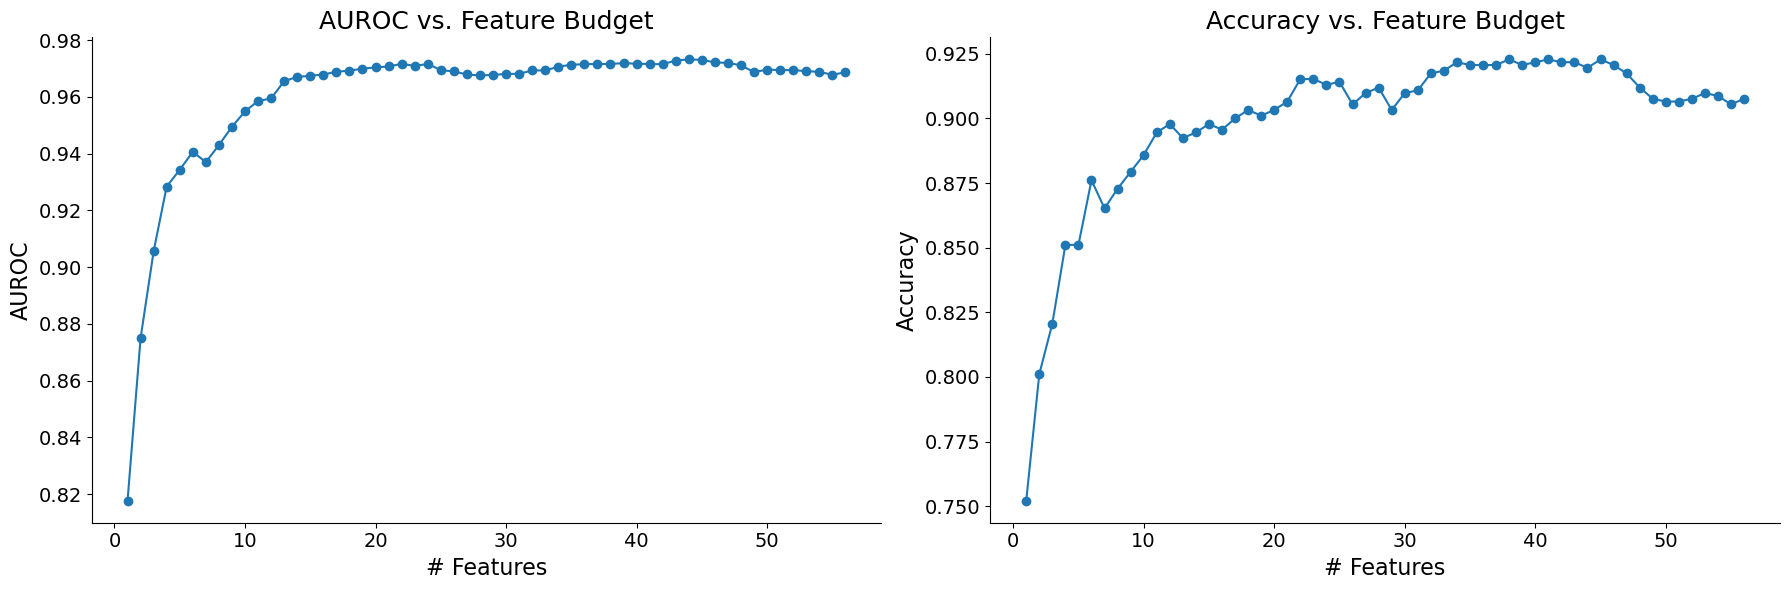

In [13]:
# Plot results
fig, axarr = plt.subplots(1, 2, figsize=(18, 6))

# AUROC
plt.sca(axarr[0])
plt.plot(num_features, auroc_list, marker='o')
plt.xlabel('# Features', fontsize=16)
plt.ylabel('AUROC', fontsize=16)
plt.title('AUROC vs. Feature Budget', fontsize=18)
plt.tick_params(labelsize=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Accuracy
plt.sca(axarr[1])
plt.plot(num_features, acc_list, marker='o')
plt.xlabel('# Features', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy vs. Feature Budget', fontsize=18)
plt.tick_params(labelsize=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

# Plot selections

In [ ]:
# Generate selections for entire test set.
num_features = range(1, 26)
p_list = []
for num in num_features:
    x, y = ds.data.get_xy(test_dataset)
    pred, x_masked, m = gdfs(x, max_features=num)#).cuda(), max_features=num)
    p = m.mean(dim=0)
    p_list.append(p.cpu().numpy())

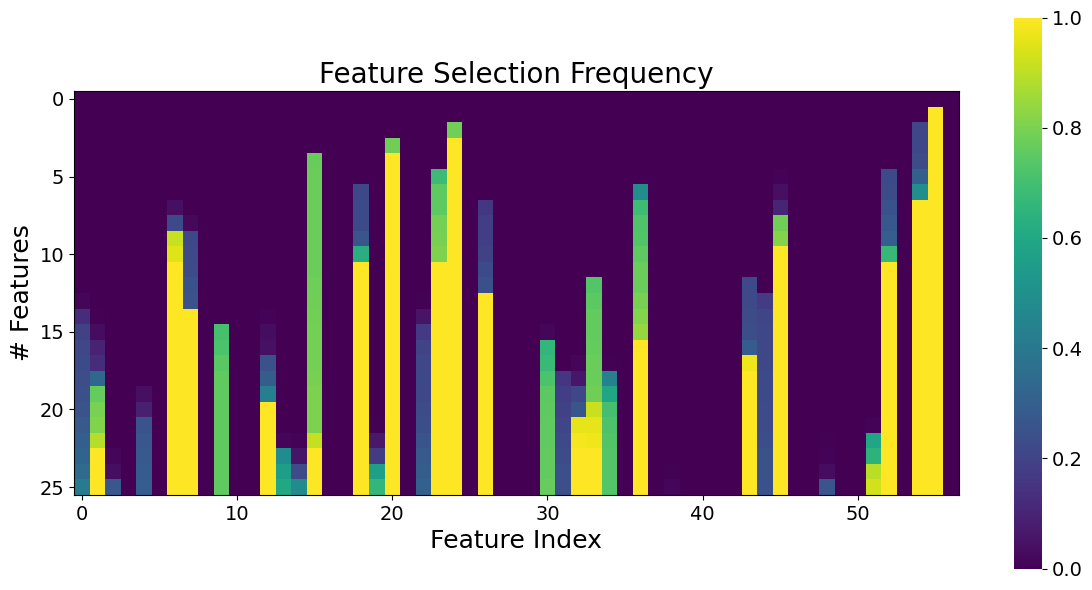

In [15]:
plt.figure(figsize=(12, 6))

# Plot heatmap.
heatmap = np.stack([np.zeros(len(p_list[0]))] + p_list)
plt.imshow(heatmap, cmap='viridis')

# Labels.
plt.xlabel('Feature Index', fontsize=18)
plt.ylabel('# Features', fontsize=18)
plt.title('Feature Selection Frequency', fontsize=20)
plt.tick_params(labelsize=14)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.outline.set_visible(False)

plt.tight_layout()
plt.show()